# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [2]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [3]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

/Users/justin/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [18]:
#your turn
#df_offers and df_transactions merge on offer_id
merged = pd.merge(df_offers, df_transactions, on = 'offer_id')
merged.head()
merged.shape
#pandas.pivot_table(data, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
merged_pivot = pd.pivot_table(merged, index = ['customer_name'], columns = 'offer_id', values ='n', fill_value = 0) #fills nan values
merged_pivot = merged_pivot.reset_index(drop = False)
print(merged_pivot.iloc[0:10,:])
print(merged_pivot.shape)

offer_id customer_name  1  2  3  4  5  6  7  8  9  ...  23  24  25  26  27  \
0                Adams  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   
1                Allen  0  0  0  0  0  0  0  0  1  ...   0   0   0   0   1   
2             Anderson  0  0  0  0  0  0  0  0  0  ...   0   1   0   1   0   
3               Bailey  0  0  0  0  0  0  1  0  0  ...   0   0   0   0   0   
4                Baker  0  0  0  0  0  0  1  0  0  ...   0   0   0   0   0   
5               Barnes  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   
6                 Bell  0  1  0  0  0  0  0  0  0  ...   0   1   0   1   0   
7              Bennett  0  0  0  0  0  0  0  1  0  ...   0   0   0   0   0   
8               Brooks  0  0  1  0  0  0  0  1  0  ...   0   0   0   0   0   
9                Brown  0  0  0  0  0  0  1  0  0  ...   0   0   0   0   0   

offer_id  28  29  30  31  32  
0          0   1   1   0   0  
1          0   0   0   0   0  
2          0   0   0   0   0  
3          0   0 

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

* https://stats.stackexchange.com/questions/48520/interpreting-result-of-k-means-clustering-in-r/48528
* https://discuss.analyticsvidhya.com/t/what-is-within-cluster-sum-of-squares-by-cluster-in-k-means/2706/2


     * Lower values of sum of squares will represent better clustering since that means distance from each data point to the centroid is minimized. A smaller SS means there is less variance in the cluster data. 

In [21]:
# your turn
#Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
#https://stackoverflow.com/questions/19170603/what-is-the-difference-between-labeled-and-unlabeled-data

import numpy as np
x_cols = np.array(merged_pivot.iloc[:,1:])
x_cols

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

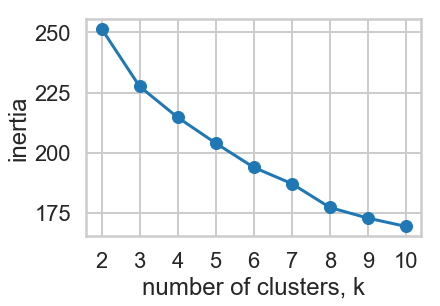

In [26]:
#Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
#Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
'''
K-Means is one of the most popular "clustering" algorithms. 
K-means stores $k$ centroids that it uses to define clusters. 
A point is considered to be in a particular cluster if it is closer to that cluster's centroid 
than any other centroid.

K-Means finds the best centroids by alternating between 
    (1) assigning data points to clusters based on the current centroids 
    (2) chosing centroids (points which are the center of a cluster) 
    based on the current assignment of data points to clusters.

A centroid is a data point (imaginary or real) at the center of a cluster. 
In Praat each centroid is an existing data point in the given input data set, picked at random, 
such that all centroids are unique (that is, for all centroids ci and cj, ci ≠ cj). 
These centroids are used to train a kNN classifier. 
The resulting classifier is used to classify (using k = 1) the data and thereby produce an initial 
randomized set of clusters. Each centroid is thereafter set to the arithmetic mean of the cluster it defines. 
The process of classification and centroid adjustment is repeated until the values of the centroids stabilize. 
The final centroids will be used to produce the final classification/clustering of the input data, 
effectively turning the set of initially anonymous data points into a set of data points, 
each with a class identity.
'''
#From Datacamp how many clusters of grain
#Import KMeans
from sklearn.cluster import KMeans

#Code for KMeans
ks = range(2,11)
inertias = []

for k in ks:
    #create a KMeans instance w/ k clusters model
    model = KMeans(n_clusters = k)
    #fit model to sample
    model.fit(x_cols)
    #append the inertia to list of inertias
    inertias.append(model.inertia_)
    
#plot ks vs inertias
plt.plot(ks,inertias,'-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

[1 0 2 1 0 0 2 1 0 1 0 2 1 0 0 2 0 2 1 0 1 0 0 0 2 0 0 0 0 2 0 1 0 0 1 1 0
 1 0 1 2 2 0 0 1 0 1 0 0 0 0 0 0 2 0 1 2 0 1 0 0 0 0 1 1 2 2 0 0 0 0 0 0 1
 0 1 2 0 1 2 0 0 0 2 1 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0]


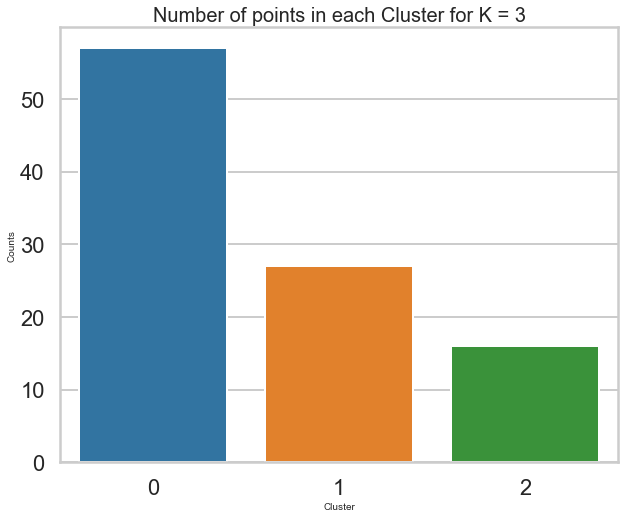

In [105]:
#Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
#I chose 8 as it looks to damper off then. 
#KMeans with a cluster of 3
kmodel = KMeans(n_clusters = 3, random_state = 42)
kmodel.fit(x_cols)
k_pred = kmodel.predict(x_cols)
print(k_pred)
#Bar Graph 
plt.figure(figsize=(10,8))
sns.countplot(k_pred)
plt.title('Number of points in each Cluster for K = 3', fontsize = 20)
plt.xlabel('Cluster', fontsize = 10)
plt.ylabel('Counts', fontsize =10)
plt.show()

* What challenges did you experience using the Elbow method to pick $K$?

    * It is hard to tell where the elbow is on the graph. It looks to be 3 but just looking a the graph it is hard to tell clearly where adding the number of ks has a diminishing affect.  3 is where it seems to be the biggest drop. 


### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.11542407037894219
For n_clusters = 4 The average silhouette_score is : 0.09670258360693122
For n_clusters = 5 The average silhouette_score is : 0.14531568820332333
For n_clusters = 6 The average silhouette_score is : 0.13313126627114877
For n_clusters = 7 The average silhouette_score is : 0.13073950771832585
For n_clusters = 8 The average silhouette_score is : 0.12397572901124844
For n_clusters = 9 The average silhouette_score is : 0.1202465110942483
For n_clusters = 10 The average silhouette_score is : 0.12695143123424532


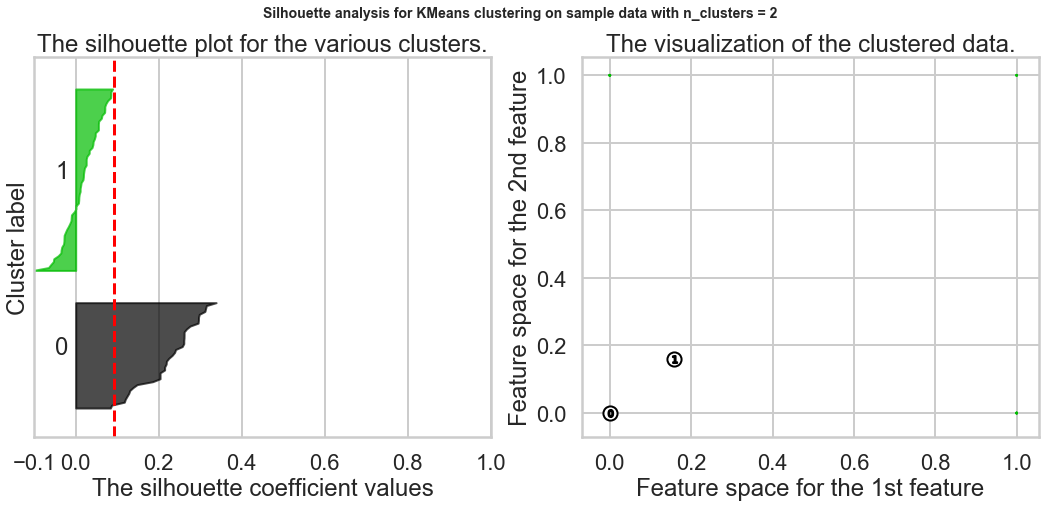

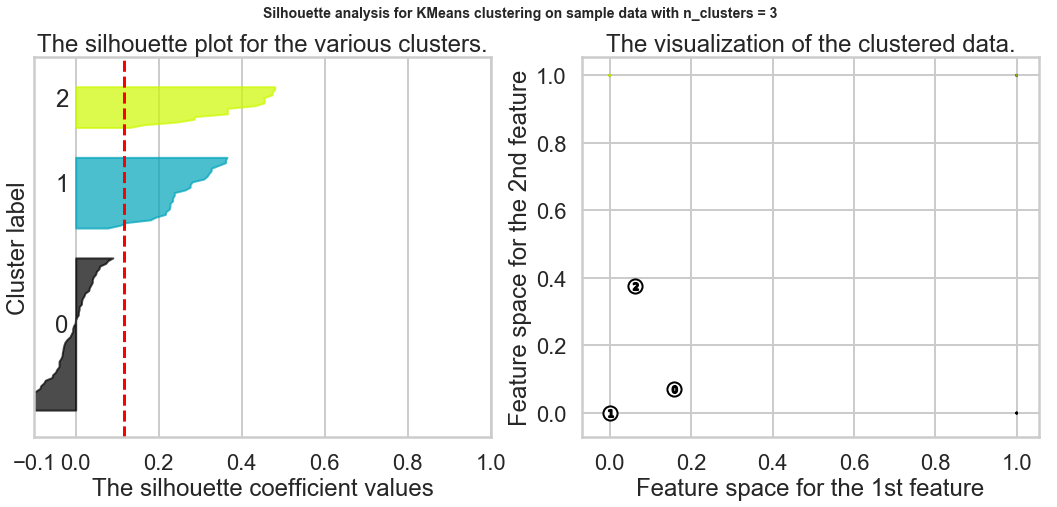

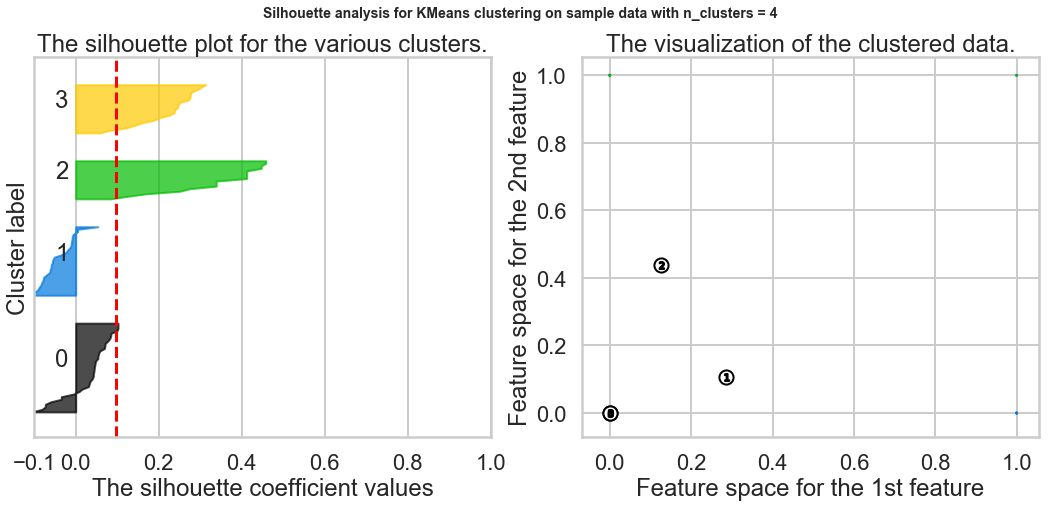

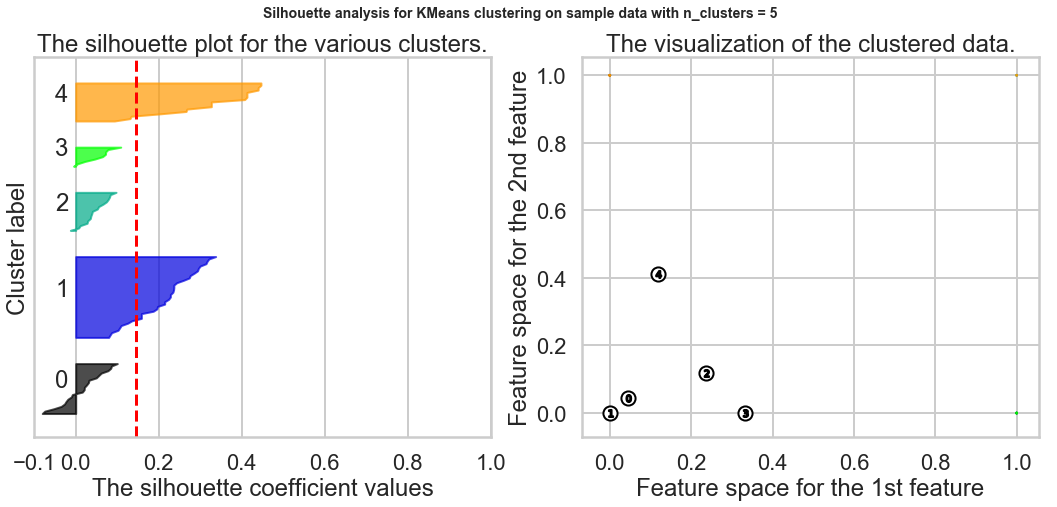

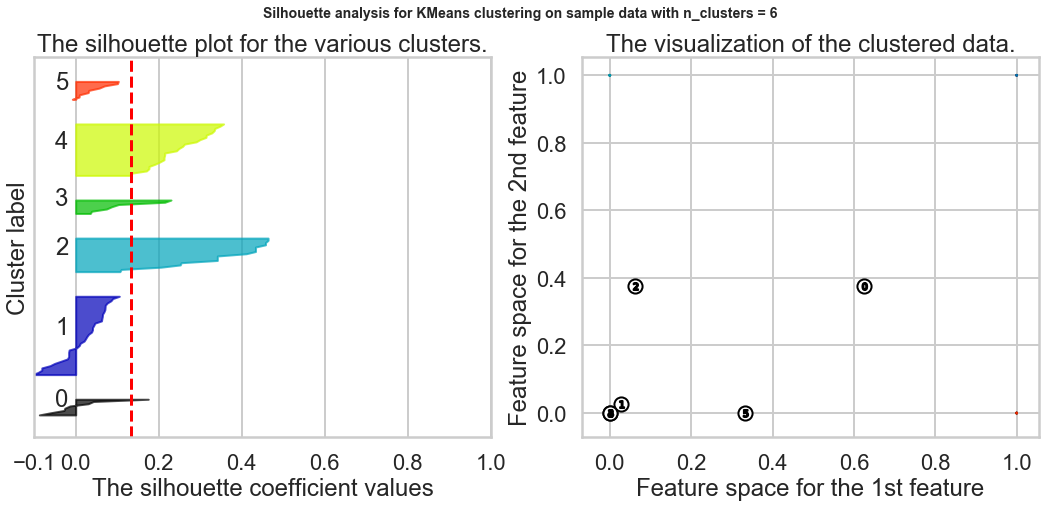

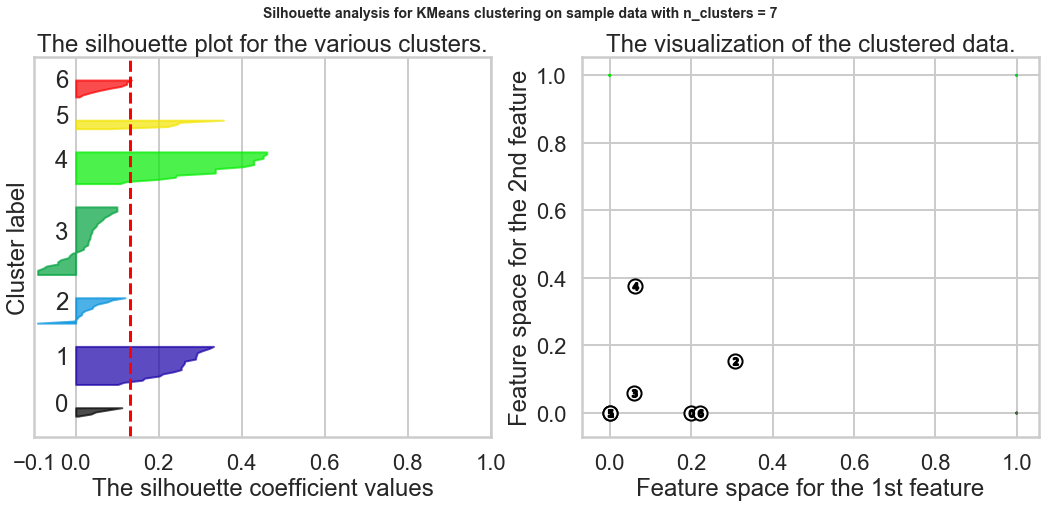

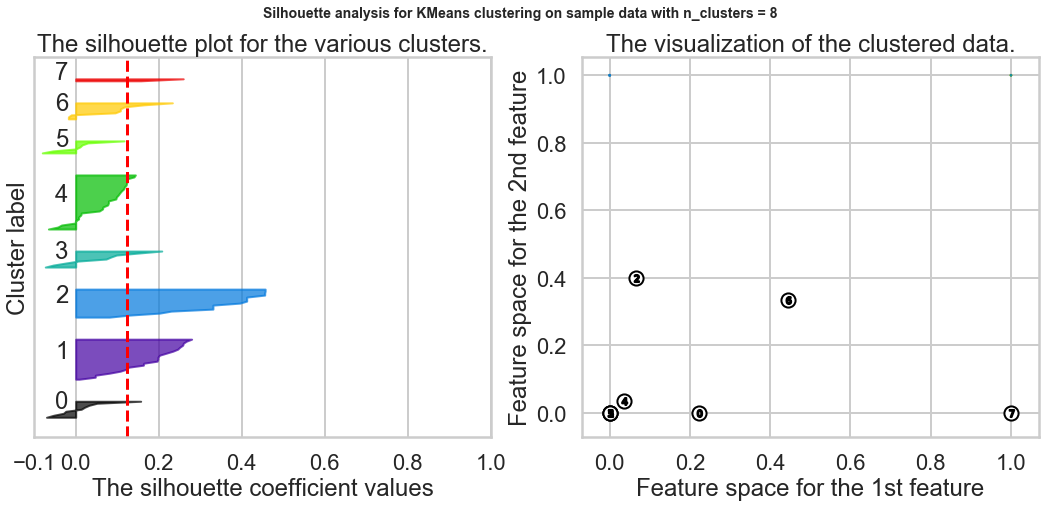

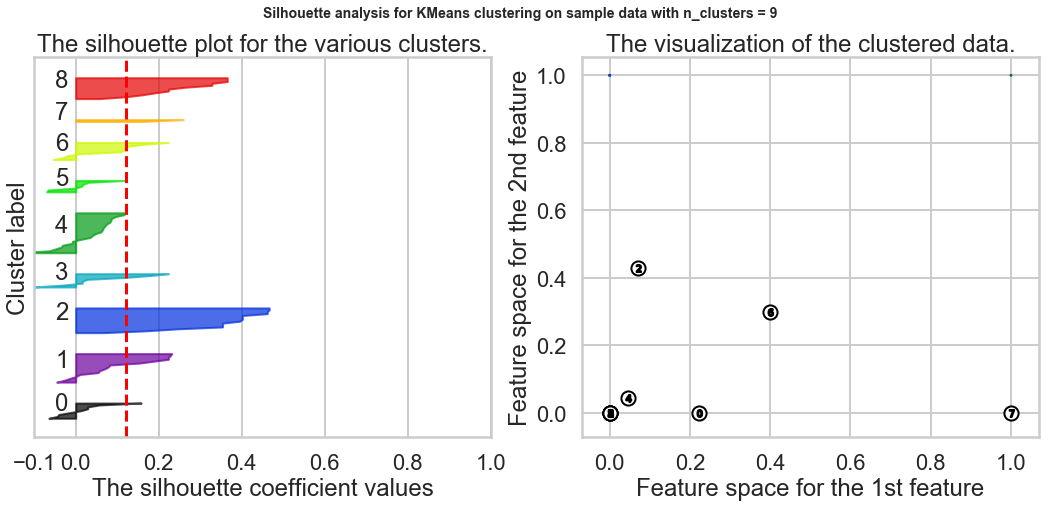

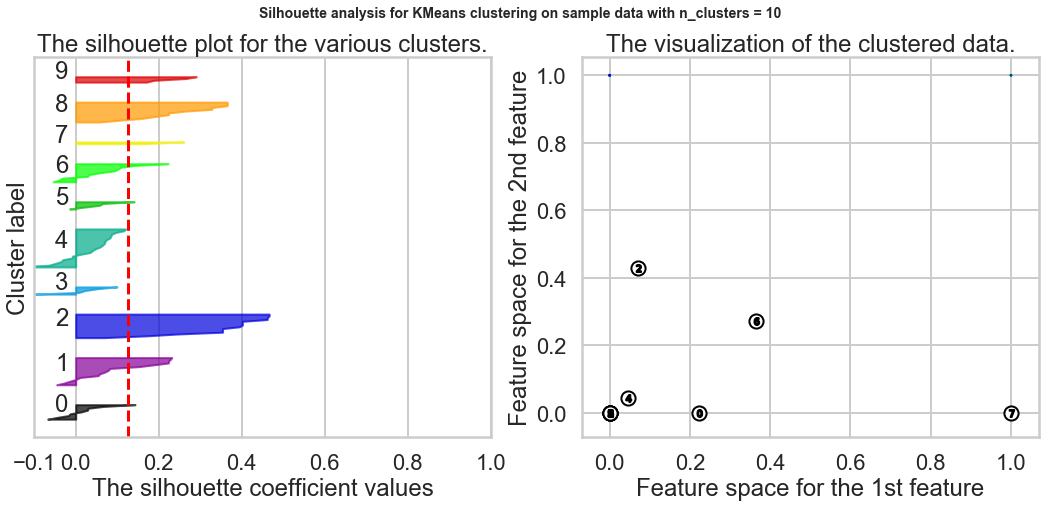

In [46]:
# Your turn.
#https://stats.stackexchange.com/questions/10540/how-to-interpret-mean-of-silhouette-plot
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.


range_n_clusters = range(2,11)
silhouette_avg_scores = [] #empty array to plot silhouette scores later 
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_cols[:, 0], x_cols[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

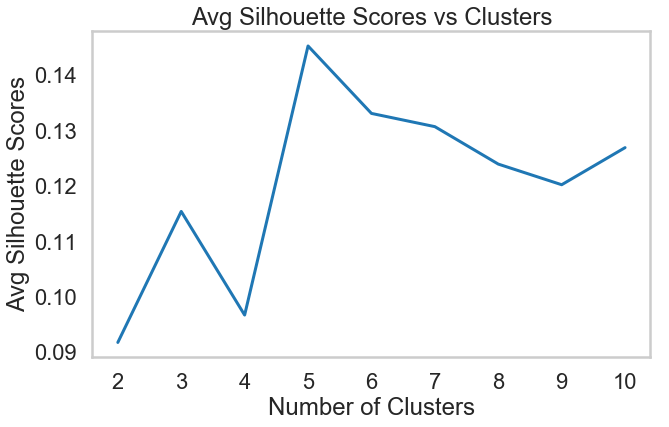

In [57]:
plt.figure(figsize=(10,6))
plt.plot(range(2,11), silhouette_avg_scores)
plt.xticks(range(2,11,1))
plt.xlabel('Number of Clusters')
plt.ylabel('Avg Silhouette Scores')
plt.title('Avg Silhouette Scores vs Clusters')
plt.grid(False)
plt.show()

* What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?
    * Just like the elbow method it's hard to tell.  The best n_clusters is at 5 at 0.145.  However this is all below 0.25 which no substantial structure can be found. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

(100, 2)


/Users/justin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


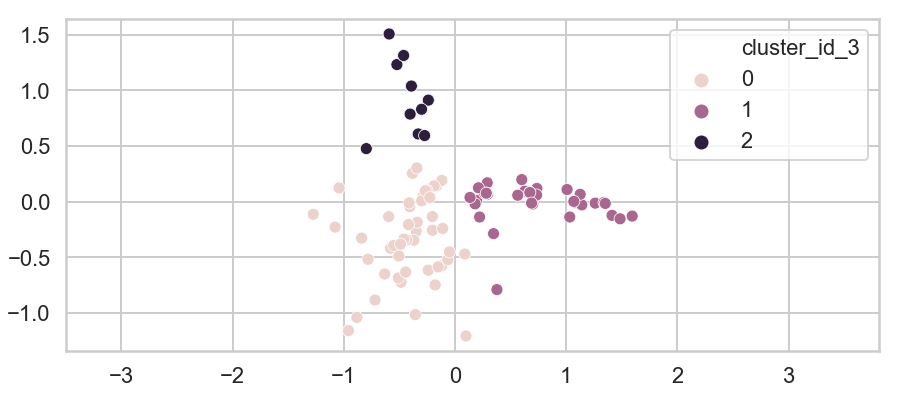

In [134]:
#your turn
#https://datascience.stackexchange.com/questions/12321/difference-between-fit-and-fit-transform-in-scikit-learn-models
#https://www.kdnuggets.com/2019/01/dimension-reduction-data-science.html

from sklearn.decomposition import PCA
model3 = KMeans(n_clusters =3)
model5 = KMeans(n_clusters = 5)
pca = PCA(n_components = 2)
pca.fit(x_cols)
pca_features = pca.fit_transform(x_cols)
print(pca_features.shape)
#customer name
#cluster id 
df = pd.DataFrame(pca_features,columns = ['x', 'y'])
df['customer_name'] = merged_pivot.customer_name
df['cluster_id_3'] = model3.fit_predict(x_cols)
df['cluster_id_5'] = model5.fit_predict(x_cols)

#assign 0th column of pca_feature
xs = pca_features[:,0]
#assign 1st column of pca_featrue
ys = pca_features[:,1]

#scatterplot xs vs ys
plt.figure(figsize=(13,6))

sns.scatterplot(xs,ys, hue = df['cluster_id_3'])
plt.tight_layout()

plt.axis('equal')
fig.show()

/Users/justin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


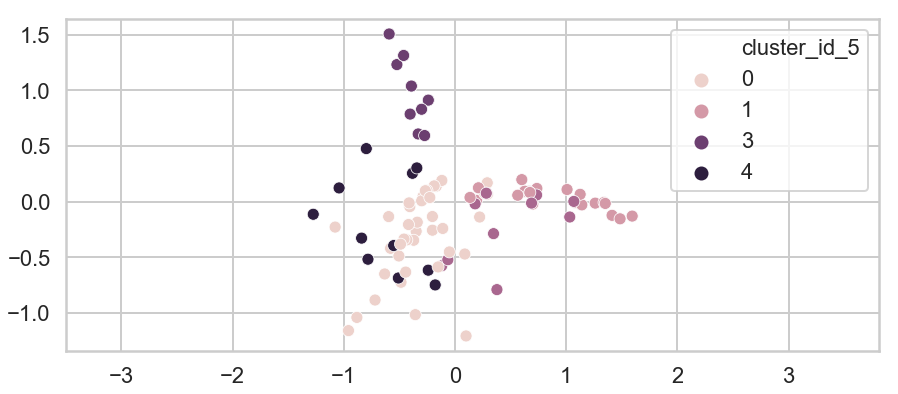

In [133]:
#cluster of 5
plt.figure(figsize=(13,6))

sns.scatterplot(xs,ys, hue = df['cluster_id_5'])
plt.tight_layout()

plt.axis('equal')
fig.show()


* How do the clusters look? 
    * K=3 seems to do a better job than K=5.  There is not as much overlap and there seems to be little to no misclassification. 
* Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?

    * K = 3 seemed to have produced the best value for K.  The elbow method seems to have produced the optimal results.   A cluster higher than 3 could cause overfitting.  


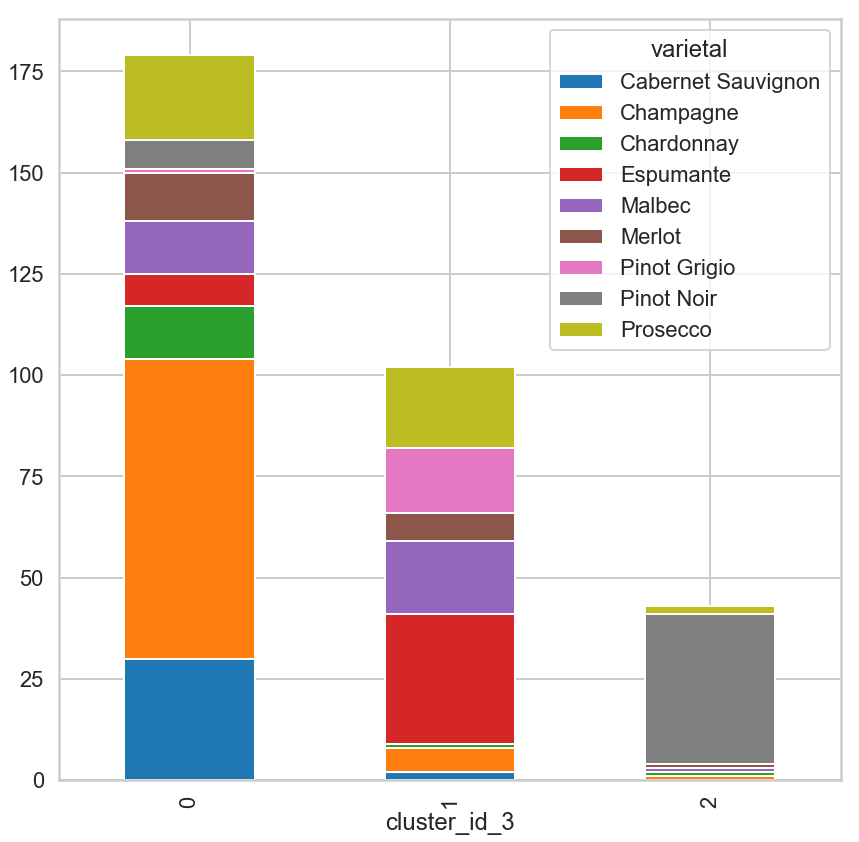

In [158]:
#Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters.
#Tell a story about the clusters in context of the original data. 
#For example, do the clusters correspond to wine variants or something else interesting? 

#take customer name and cluster_id 3 and 5 out
data = df.loc[:,['customer_name','cluster_id_3','cluster_id_5']]
#merge the clusters to the original data frame
data2 = pd.merge(merged,data,on='customer_name')

#lets look at how the clusters do with wine variants
#https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.crosstab.html
winevariant = pd.crosstab( data2['cluster_id_3'],data2['varietal'])
winevariant.plot(kind = 'bar',stacked =True, figsize = (14,14))
plt.xticks(range(0,3))
plt.show()

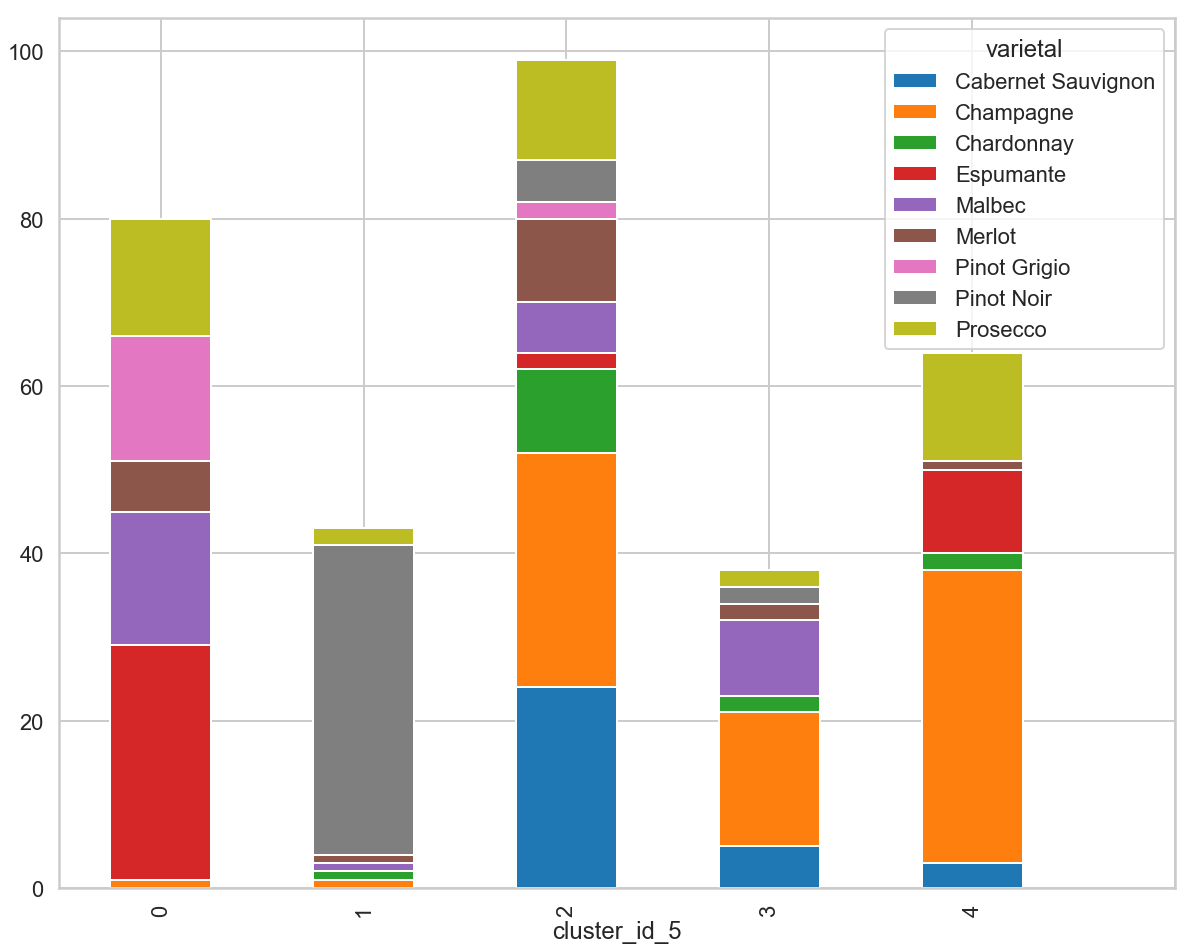

In [162]:
#a cluster of 5
winevariant = pd.crosstab( data2['cluster_id_5'],data2['varietal'])
winevariant.plot(kind = 'bar',stacked =True, figsize = (20,16))
plt.xticks(range(0,6))
plt.show()

* Using a cluster of 5 rather than 3 tells a more complete story for cluster groups choosing wine. Espumante seems to be quite popular with cluster 0.  While pinot noir is popular with cluster 1. Champagne is most popular with cluster groups 2,3 and 4. 

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

(32,)


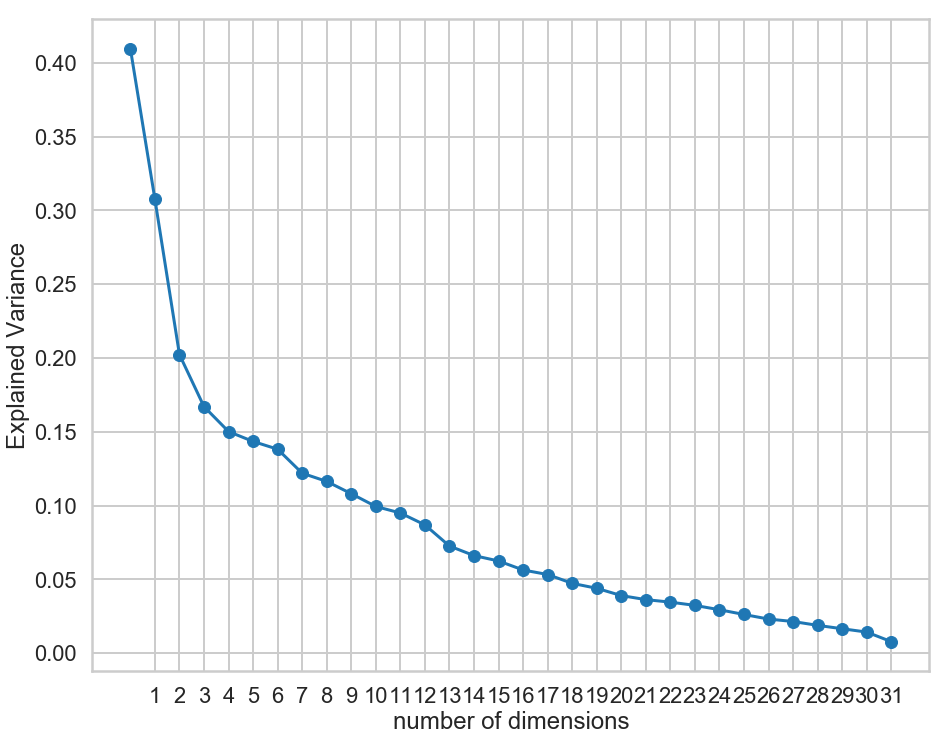

In [180]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)
print(pca.explained_variance_.shape)
# Do the rest on your own
plt.figure(figsize = (15,12))
plt.plot(pca.explained_variance_,'-o')
plt.xticks(range(1,32,1))
plt.xlabel('number of dimensions')
plt.ylabel('Explained Variance')
plt.show()

* Looking at the elbow plot the optimal number of dimensions looks to be at 4. 

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [439]:
# Your turn
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
#Affinity propagation
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html
n_clus = np.linspace(0.5,1,10,endpoint= False) #returns 20 values between 0.5 to 1

for k in n_clus:
    clustering = AffinityPropagation(damping = k)
    cluster_labels = clustering.fit_predict(x_cols)
    sil_score = silhouette_score(x_cols, cluster_labels,random_state =42)
    print(f'With Damping: {k:.2f}, it has a silhouette score of {sil_score:.4f}')

With Damping: 0.50, it has a silhouette score of 0.1235
With Damping: 0.55, it has a silhouette score of 0.1235
With Damping: 0.60, it has a silhouette score of 0.1235
With Damping: 0.65, it has a silhouette score of 0.1235
With Damping: 0.70, it has a silhouette score of 0.1235
With Damping: 0.75, it has a silhouette score of 0.1235
With Damping: 0.80, it has a silhouette score of 0.0895
With Damping: 0.85, it has a silhouette score of 0.0895
With Damping: 0.90, it has a silhouette score of 0.0895
With Damping: 0.95, it has a silhouette score of 0.0895


* For Affinity propagation the best was with a damping of 0.5 having a silhouette score of 0.1235.

In [438]:
#Spectral clustering
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
from sklearn.cluster import SpectralClustering
n_clus = range(2,15)

for k in n_clus:
    clustering = SpectralClustering(n_clusters = k,random_state = 42)
    cluster_labels = clustering.fit_predict(x_cols)
    sil_score = silhouette_score(x_cols, cluster_labels)
    print(f'With number of clusters: {k}, it has a silhouette score of {sil_score:.4f}')

With number of clusters: 2, it has a silhouette score of 0.0763
With number of clusters: 3, it has a silhouette score of 0.1061
With number of clusters: 4, it has a silhouette score of 0.0863
With number of clusters: 5, it has a silhouette score of 0.0992
With number of clusters: 6, it has a silhouette score of 0.0985
With number of clusters: 7, it has a silhouette score of 0.0760
With number of clusters: 8, it has a silhouette score of 0.0777
With number of clusters: 9, it has a silhouette score of 0.0871
With number of clusters: 10, it has a silhouette score of 0.0858
With number of clusters: 11, it has a silhouette score of 0.0987
With number of clusters: 12, it has a silhouette score of 0.0692
With number of clusters: 13, it has a silhouette score of 0.0354
With number of clusters: 14, it has a silhouette score of 0.0692


 * Spectral clustering the optimal clustering is at 3 given a silhouette score of 0.1061

In [440]:
# Agglomerative clustering
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
#https://www.youtube.com/watch?v=XJ3194AmH40
#from above we got a silhouette score of 5 
from sklearn.cluster import AgglomerativeClustering
n_clus = range(2,15)

for l in n_clus:
    clustering = AgglomerativeClustering(n_clusters = l)
    cluster_labels = clustering.fit_predict(x_cols)
    sil_score = silhouette_score(x_cols, cluster_labels,random_state = 42)
    print(f'For clusters {l} has a Silhouette Score {sil_score:.4f}')

For clusters 2 has a Silhouette Score 0.0826
For clusters 3 has a Silhouette Score 0.1163
For clusters 4 has a Silhouette Score 0.1289
For clusters 5 has a Silhouette Score 0.1409
For clusters 6 has a Silhouette Score 0.1472
For clusters 7 has a Silhouette Score 0.1528
For clusters 8 has a Silhouette Score 0.1558
For clusters 9 has a Silhouette Score 0.1208
For clusters 10 has a Silhouette Score 0.0975
For clusters 11 has a Silhouette Score 0.1050
For clusters 12 has a Silhouette Score 0.1044
For clusters 13 has a Silhouette Score 0.1095
For clusters 14 has a Silhouette Score 0.1157


In [435]:
# Agglomerative clustering

"""
Agglomerative: This is a "bottom-up" approach: each observation starts in its own cluster, 
and pairs of clusters are merged as one moves up the hierarchy.
"""
#best score happens at 4 lets see if linkage method does anything
linkage = ['ward', 'complete', 'average', 'single']

for l in linkage:
    clustering = AgglomerativeClustering(n_clusters = 8, linkage =l)
    clustering = clustering.fit(x_cols)
    cluster_labels = clustering.fit_predict(x_cols)
    sil_score = silhouette_score(x_cols, cluster_labels,random_state = 42)
    print(f'For linkage method: {l} has a Silhouette Score {sil_score:.4f}')

For linkage method: ward has a Silhouette Score 0.1558
For linkage method: complete has a Silhouette Score 0.1114
For linkage method: average has a Silhouette Score 0.1053
For linkage method: single has a Silhouette Score 0.0609


* Using ward method for linkage with a cluster of 8 got a score of 0.1558

In [441]:
#DBSCAN
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
#https://www.quora.com/How-does-DBSCAN-algorithm-work
#For some reason couldn't use our PCA here 
from sklearn.cluster import DBSCAN
list_ = [1,2]
for l in list_:
    clustering = DBSCAN(eps = l)
    labels = clustering.fit_predict(x_cols)
    sil_score = silhouette_score(x_cols, labels, random_state =42)
    print(f'Using DBSCAN we got a silhouette score of {sil_score:.4f} with eps {l}')

Using DBSCAN we got a silhouette score of 0.0127 with eps 1
Using DBSCAN we got a silhouette score of 0.2349 with eps 2


* Using eps of 2 got us a silhouette score of 0.2566 using DBSCAN.

* How do their results compare? Which performs the best? Tell a story why you think it performs the best.
    * The best silouette scores were 
            KMeans: 0.1453
            Affinity: 0.1235
            Spectral: 0.1061 
            Agglomerative: 0.1558
            DBSCAN : 0.2349


https://en.wikipedia.org/wiki/DBSCAN


https://towardsdatascience.com/dbscan-clustering-for-data-shapes-k-means-cant-handle-well-in-python-6be89af4e6ea

A DBSCAN is good finding core samples of high density and expanding from them; good for data that contains clusters of similar density. The clusters maybe spread out without any clear clusters and perhaps that's why DBSCAN did the best as it can identify points that are not part of any cluster (very useful as outliers detector). 
